In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os
import joblib
import tensorflow as tf
import keras

from keras.layers import Input
from keras import backend as K 
from keras.preprocessing.image import ImageDataGenerator 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import layers, models, optimizers 
from keras.applications import ResNet50
from keras.models import Sequential, Model
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [4]:
DATA_PATH = '../input/bengaliai-cv19/'
TRAIN_DIR = DATA_PATH + 'train_image/'

IMAGE_SIZE = 128
BATCH_SIZE = 128
EPOCHS = 30
PATIENT = 5

MODEL_PATH = '../model_ckpt/baseline_v1/'
MODEL_NAME = 'baseline_v1'
label = pd.read_csv(DATA_PATH+'train_label_folds.csv')

In [5]:
label.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,id,fold
0,Train_0,15,9,5,ক্ট্রো,0,2
1,Train_1,159,0,0,হ,1,3
2,Train_2,22,3,5,খ্রী,2,1
3,Train_3,53,2,2,র্টি,3,4
4,Train_4,71,9,5,থ্রো,4,2


In [18]:
def build_model(image_size):
    x_in = layers.Input(shape=(image_size, image_size, 1))
    x = layers.Conv2D(3, (3,3), padding='same')(x_in)
    base_model = ResNet50(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)
    x = base_model(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    out_grapheme = layers.Dense(168, activation='softmax', name='grapheme')(x)
    out_vowel = layers.Dense(11, activation='softmax', name='vowel')(x)
    out_consonant = layers.Dense(7, activation='softmax', name='consonant')(x)
    
    model = Model(inputs=x_in, outputs=[out_grapheme, out_vowel, out_consonant])
    model.summary()
    
    optimizer = optimizers.RMSprop(lr=0.0001)
# multi output compile
    model.compile(optimizer,
                  loss={'grapheme': 'sparse_categorical_crossentropy',
                        'vowel': 'sparse_categorical_crossentropy',
                        'consonant': 'sparse_categorical_crossentropy'},
                  loss_weights={'grapheme': 0.5,        ## Set weights
                                'vowel': 0.25,
                                'consonant': 0.25},
                  metrics={'grapheme': 'accuracy',
                           'vowel': 'accuracy',
                           'consonant': 'accuracy'}
                 )

    return model

In [19]:
def get_callback(model_name, patient):
    
    ES = EarlyStopping(
        monitor='val_loss', 
        patience=patient, 
        mode='min', 
        verbose=1)
    
    RR = ReduceLROnPlateau(
        monitor = 'val_loss', 
        factor = 0.1, 
        patience = 2, 
        min_lr=0.000001, 
        verbose=1, 
        mode='min')
    
    MC = ModelCheckpoint(
        filepath=MODEL_PATH+model_name, 
        monitor='val_loss', 
        verbose=1, 
        save_best_only=True, 
        mode='min')

    return [ES, RR, MC]

In [20]:
model = build_model(IMAGE_SIZE);

/home/dongeun/anaconda3/envs/bengal/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 3)  30          input_3[0][0]                    
__________________________________________________________________________________________________
resnet50 (Model)                (None, 4, 4, 2048)   23587712    conv2d_2[0][0]                   
__________________________________________________________________________________________________
global_average_pooling2d_2 (Glo (None, 2048)         0           resnet50[1][0]                   
____________________________________________________________________________________________

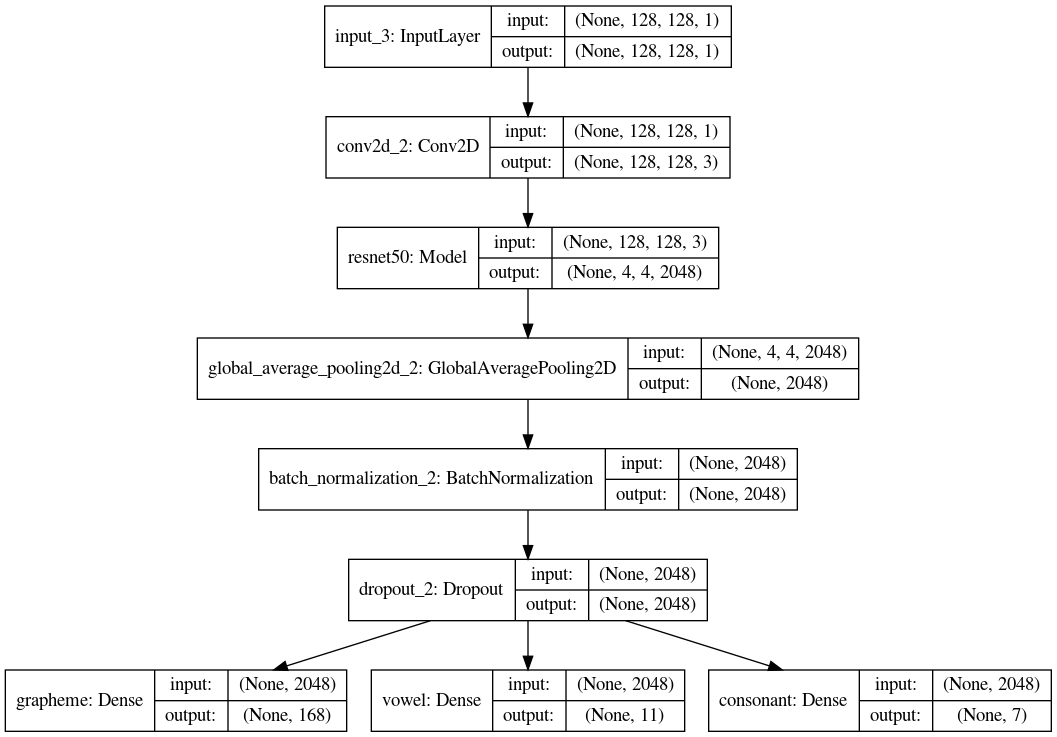

In [21]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [10]:
label['grapheme_root'] = label['grapheme_root'].astype(str)
label['vowel_diacritic'] = label['vowel_diacritic'].astype(str)
label['consonant_diacritic'] = label['consonant_diacritic'].astype(str)

In [11]:
#split train_label by fold (5fold)
label['id'] = label['id'].apply(lambda x : 'Train_'+str(x)+'.jpg')
val_label = label[label['fold']==4]
train_label = label[label['fold']!=4]

In [12]:
print(train_label['fold'].unique())
print(val_label['fold'].unique())

[2 3 1 0]
[4]


In [13]:
train_label.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,id,fold
0,Train_0,15,9,5,ক্ট্রো,Train_0.jpg,2
1,Train_1,159,0,0,হ,Train_1.jpg,3
2,Train_2,22,3,5,খ্রী,Train_2.jpg,1
4,Train_4,71,9,5,থ্রো,Train_4.jpg,2
6,Train_6,52,2,0,ঞ্জি,Train_6.jpg,2


In [14]:
TRAIN_DIR

'../input/bengaliai-cv19/train_image/'

In [15]:
train_datagen = ImageDataGenerator(
    rescale = 1./255)

valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [16]:
train_generator = train_datagen.flow_from_dataframe(
            dataframe=train_label,
            directory=TRAIN_DIR,
            x_col='id',
            y_col=['grapheme_root','vowel_diacritic','consonant_diacritic'],
            target_size= (IMAGE_SIZE, IMAGE_SIZE),
            color_mode='grayscale',
            class_mode='multi_output',
            batch_size=BATCH_SIZE,
            seed=42
            )

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=val_label,
    directory=TRAIN_DIR,
    x_col='id',
    y_col=['grapheme_root','vowel_diacritic','consonant_diacritic'],
    target_size= (IMAGE_SIZE, IMAGE_SIZE),
    color_mode='grayscale',
    class_mode='multi_output',
    batch_size=BATCH_SIZE,
    seed=42
    )

Found 40187 validated image filenames.
Found 10023 validated image filenames.


/home/dongeun/anaconda3/envs/bengal/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 120485 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/home/dongeun/anaconda3/envs/bengal/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 30145 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [22]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_label.index) / BATCH_SIZE,
    epochs= EPOCHS,
    validation_data= valid_generator,
    validation_steps=len(val_label.index) / BATCH_SIZE,
    callbacks = get_callback(MODEL_NAME, PATIENT),
    verbose=1)

Epoch 1/30
1256/1255 [==============================] - 297s 236ms/step - loss: 0.9278 - grapheme_loss: 1.4563 - vowel_loss: 0.4264 - consonant_loss: 0.3723 - grapheme_accuracy: 0.6688 - vowel_accuracy: 0.8707 - consonant_accuracy: 0.8917 - val_loss: 0.4866 - val_grapheme_loss: 0.8124 - val_vowel_loss: 0.1906 - val_consonant_loss: 0.2031 - val_grapheme_accuracy: 0.7905 - val_vowel_accuracy: 0.9465 - val_consonant_accuracy: 0.9518

Epoch 00001: val_loss improved from inf to 0.48656, saving model to ../model_ckpt/baseline_v1/baseline_v1
Epoch 2/30
1256/1255 [==============================] - 289s 230ms/step - loss: 0.0942 - grapheme_loss: 0.1330 - vowel_loss: 0.0576 - consonant_loss: 0.0531 - grapheme_accuracy: 0.9593 - vowel_accuracy: 0.9823 - consonant_accuracy: 0.9844 - val_loss: 0.4157 - val_grapheme_loss: 0.6881 - val_vowel_loss: 0.1822 - val_consonant_loss: 0.1923 - val_grapheme_accuracy: 0.8453 - val_vowel_accuracy: 0.9571 - val_consonant_accuracy: 0.9617

Epoch 00002: val_loss im